In [1]:
sys.path.append('C:/Users/nyasha/Desktop/Masters-Nyasha/Models')

import sys

import torch
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from DatasetCreator import HAVSDataset

from CAE import *
from training_functions import *

In [2]:
"""
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()
"""

"\nimport torch\nimport torchvision\nfrom torch.utils.tensorboard import SummaryWriter\nfrom torchvision import datasets, transforms\n\n# Writer will output to ./runs/ directory by default\nwriter = SummaryWriter()\n\ntransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])\ntrainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)\nmodel = torchvision.models.resnet50(False)\n# Have ResNet model take in grayscale rather than RGB\nmodel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)\nimages, labels = next(iter(trainloader))\n\ngrid = torchvision.utils.make_grid(images)\nwriter.add_image('images', grid, 0)\nwriter.add_graph(model, images)\nwriter.close()\n"

In [2]:
BATCH_SIZE = 128
NUM_EPOCHS = 25

In [3]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz"
x_train, x_test, x_val, y_train, y_test, y_val = get_train_test_data(compressed_file_path)

In [ ]:
# Check if files have been imported correctly
print(x_train.shape)  
print(x_test.shape)
print(x_val.shape)
print(y_train.shape) 
print(y_test.shape)
print(y_val.shape)

In [12]:
# Check if type is correct
print(type(x_train))  
print(type(x_test))
print(type(x_val))
print(type(y_train)) 
print(type(y_test))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
# Define the transforms
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

In [5]:
# Create the datasets
train_dataset = HAVSDataset(x_train, y_train, transform=transform)
val_dataset = HAVSDataset(x_val, y_val, transform=transform)
test_dataset = HAVSDataset(x_test, y_test, transform=transform)

In [6]:
# Creating the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ## encoder layers ##

        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) 
    
        self.conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # add second hidden layer
        """"
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # compressed representation
        """

        return x

class Decoder(nn.Module):
    def __init__(self):

        super(Decoder, self).__init__()
        self.dconv1 = nn.ConvTranspose2d(16, 32, 3, padding=1, stride=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.dconv2 = nn.ConvTranspose2d(32, 1, 3, padding=1, stride=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, encode):
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.dconv1(encode))
        x = self.upsample1(x)

        x = F.relu(self.dconv2(x))
        x = self.upsample2(x)
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(x)

        return x

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, img):
        x = self.encoder(img)
        x = self.decoder(x)
        
        return x



In [7]:
# Select a model from ../Models
model_1  = CAE()
(model_1._get_name()) 

'CAE'

In [8]:
# Get number of parameters
pytorch_total_params_model_1 = sum(p.numel() for p in model_1.parameters())
print(f"The number of  parameters in this model is {pytorch_total_params_model_1}")

The number of  parameters in this model is 2633


In [9]:
device = get_device() 
model_on_device = model_1.to(device) # Move model to the current device

Running on the GPU


In [10]:
# Specify loss function
criterion = nn.BCELoss()

# Specify optimizer
optimizer = torch.optim.SGD(model_on_device.parameters(), lr=0.01)

In [11]:
criterion._get_name()

'BCELoss'

In [12]:
str(optimizer)

'SGD (\nParameter Group 0\n    dampening: 0\n    lr: 0.01\n    momentum: 0\n    nesterov: False\n    weight_decay: 0\n)'

In [14]:
# Train the CAE reconstruction model
train_cae(30, train_loader, criterion, optimizer, device, model_on_device)


C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
Epoch: 1 	Training Loss: 90.088782
Epoch: 2 	Training Loss: 87.696524
Epoch: 3 	Training Loss: 87.512968
Epoch: 4 	Training Loss: 87.429177
Epoch: 5 	Training Loss: 87.379804
Epoch: 6 	Training Loss: 87.346476
Epoch: 7 	Training Loss: 87.323322
Epoch: 8 	Training Loss: 87.304959
Epoch: 9 	Training Loss: 87.291509
Epoch: 10 	Training Loss: 87.280258
Epoch: 11 	Training Loss: 87.271014
Epoch: 12 	Training Loss: 87.263359
Epoch: 13 	Training Loss: 87.256498
Epoch: 14 	Training Loss: 87.250695
Epoch: 15 	Training Loss: 87.245934
Epoch: 16 	Training Loss: 87.241702
Epoch: 17 	Training Loss: 87.238014
Epoch: 18 	Traini

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
Original Images


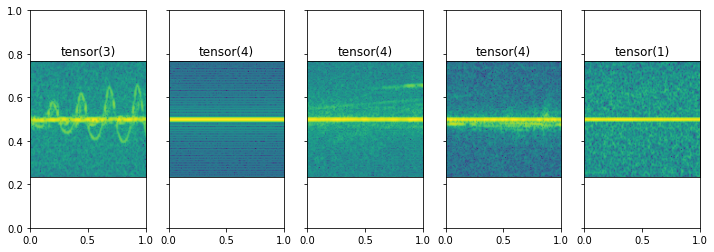

Reconstructed Images


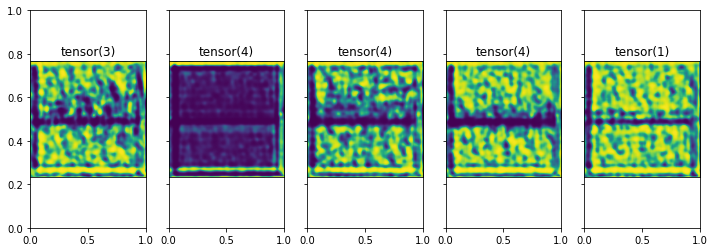

In [13]:
# Visualize CAE model performance
visualise_cae_performance(train_loader, device, model_on_device, 128, 128, 128)

In [11]:
model_on_device

CAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (dconv1): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample1): Upsample(scale_factor=2.0, mode=bilinear)
    (dconv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample2): Upsample(scale_factor=2.0, mode=bilinear)
  )
)

In [12]:
# Freeze model weights
for param in model_on_device.parameters():
    param.requires_grad = False

In [13]:
class Flatten(nn.Module):
    """Flattening CNN output"""
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [14]:
# Remove transpose layer

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device, dtype=torch.float)
net2 = nn.Sequential(*list(model_on_device.children())[:-1])
net2.eval() # Switch to evaluation mode
net2(images).shape
net2.add_module('flatten', Flatten())
dense_in = net2(images.cuda()).shape[1] # Get the dense layer shape


In [16]:
dense_in

8192

In [17]:
# Replace the model's decoder with dense layer
model_on_device.decoder = nn.Sequential(
    Flatten(),
    nn.Linear(dense_in, 6),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

In [18]:
model_on_device = model_on_device.to(device)

In [19]:


class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adamax(model_on_device.parameters(), lr=0.01)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['2_walking' 'clutter/noise' 'running' 'sphere_swing' 'vehicle' 'walking'], y=['walking' 'walking' 'vehicle' ... 'running' 'clutter/noise' 'vehicle'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [20]:
print(1)

1


In [21]:
optimizer

Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [53]:

def get_info(optimizer):
    format_string = optimizer.__class__.__name__ + '_'
    for i, group in enumerate(optimizer.param_groups):
        for key in sorted(group.keys()):
            if key != 'params':
                format_string += '_{0}_{1}'.format(key, group[key])
    format_string += ''
    return format_string

In [54]:
get_info(optimizer)

'Adamax__betas_(0.9, 0.999)_eps_1e-08_lr_0.01_weight_decay_0'

In [44]:
def train_model(num_epochs, train_loader, val_loader, criterion, optimizer, device, model_on_device):

    writer = SummaryWriter()
    num_batches = len(train_loader)
    for epoch in range(1, num_epochs+1):
        model_on_device.train() # Turn on Dropout, BatchNorm etc
        train_loss_per_batch = np.empty(num_batches)
        accuracy_per_batch = np.empty(num_batches)
        train_loss = 0
        correct = 0
        total = 0
        accuracy = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)
            output = model_on_device(images)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            optimizer.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/images.shape[0]
            accuracy = 100 * correct / total

            train_loss_per_batch[batch_idx] =  train_loss
            accuracy_per_batch[batch_idx] = accuracy

        avg_epoch_train_loss = np.mean(train_loss_per_batch)
        avg_epoch_accuracy = np.mean(accuracy_per_batch)

        print("Evaluating performance on validation data")
        test_loss, test_accuracy = evaluate_model(val_loader, device, model_on_device, criterion)

        writer.add_scalar('Loss/Train', avg_epoch_train_loss, epoch)
        writer.add_scalar('Accuracy/Train', avg_epoch_accuracy, epoch)
        writer.add_scalar('Loss/Validation', test_loss, epoch)
        writer.add_scalar('Accuracy/Validation', test_accuracy, epoch)
        
        
        print('Epoch: {}/{} \t Training Loss: {}, Accuracy: {}, Testing Loss: {}, Accuracy: {}'.format(epoch, num_epochs, train_loss, accuracy, test_loss, test_accuracy))
    
    writer.close()

In [24]:
# Train the classification model
train_model(2
, train_loader, val_loader, criterion, optimizer, device, model_on_device)

Evaluating performance on validation data
Accuracy of the network on the test images: 11 %
Epoch: 1/2 	 Training Loss: 2.6943, Accuracy: 11.46, Testing Loss: 1.8778, Accuracy: 11.48
Evaluating performance on validation data
Accuracy of the network on the test images: 11 %
Epoch: 2/2 	 Training Loss: 2.6945, Accuracy: 11.46, Testing Loss: 1.8767, Accuracy: 11.48


In [23]:
# Evaluate model performance on test data
evaluate_model(test_loader, device, model_on_device)

TypeError: evaluate_model() missing 1 required positional argument: 'criterion'

In [58]:
train_model(NUM_EPOCHS, train_loader, criterion, optimizer, device, model_on_device)

Epoch: 1/1 	 Training Loss: 1.8935127835720778, Accuracy: 72.85421127765882
